**Import statements**


In [26]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import constants
import functions

%matplotlib inline

**Load Data**

In [27]:
all_static_data = functions.load_static_sensors_calibrated()
all_static_data = functions.transform_to_grid_coordinates(all_static_data)
mobile_sensor_data = functions.load_mobile_sensors()
mobile_sensor_data = functions.transform_to_grid_coordinates(mobile_sensor_data)

**Compute predictions for stationary sensors**

In [28]:
mae = []
mse = []
squares = []
pred=[]

start_time = '2018-07-03 00:00:00'
start_window = '2018-07-05 14:00:00'
end_window = '2018-07-05 14:15:00'
offset_timeint = 1

number_of_windows = 100
window = 15
par_grid = functions.create_par(c=0.00002, epsilon=0.001)
timeint_on_first_window = 0

for i in range(1, number_of_windows+1):
    end_time = start_window
    # treinar sem dados moveis
    # testar em dados fixos em vez de móveis
    timeint, par_grid = functions.train(all_static_data, None, start_time, end_time, par_grid, window, timeint_on_first_window)
    to_test = functions.test_mobile(par_grid, timeint, all_static_data, start_window, end_window, 1)
    squares.append(to_test.shape[0])
    mae.append(mean_absolute_error(to_test['PM2.5'], to_test['pred_PM2.5']))
    mse.append(mean_squared_error(to_test['PM2.5'], to_test['pred_PM2.5']))
    pred.append(to_test['pred_PM2.5'].values[0])

    start_time = end_time
    start_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
    end_window = (datetime.strptime(end_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
    timeint_on_first_window = timeint+1
    

In [29]:
# mae

In [30]:
mae_no_online = []
mse_no_online = []
squares_no_online = []
pred_no_online=[]
values_read=[]


window = 15
start_window = '2018-07-05 14:00:00'
end_window = '2018-07-05 14:15:00'
offset_timeint = 1
number_of_windows = 100
par_grid = functions.create_par(c=0.00002, epsilon=0.001)
start_time = '2018-07-03 00:00:00'
end_time = start_window
timeint, par_grid = functions.train(all_static_data, None, start_time, end_time, par_grid, window)


for i in range(1, number_of_windows+1):
    to_test = functions.test_mobile(par_grid, timeint, all_static_data, start_window, end_window, i)
    squares_no_online.append(to_test.shape[0])
    mae_no_online.append(mean_absolute_error(to_test['PM2.5'], to_test['pred_PM2.5']))
    mse_no_online.append(mean_squared_error(to_test['PM2.5'], to_test['pred_PM2.5']))
    pred_no_online.append(to_test['pred_PM2.5'].values[0])
    values_read.append(to_test['PM2.5'].values[0])
    start_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
    end_window = (datetime.strptime(end_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")

In [31]:
# mae_no_online

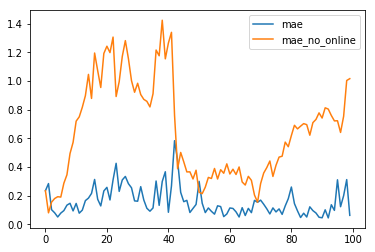

In [32]:
plt.plot(mae, label="mae")
plt.plot(mae_no_online, label="mae_no_online")
plt.legend(loc='best')
plt.show()


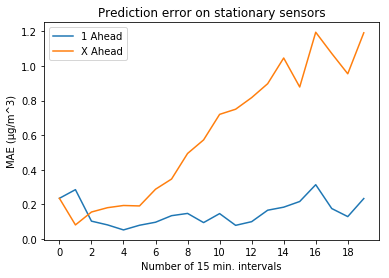

In [33]:
# Make sure in functions there is no constraint on the sensor to use.
# Insert the hyperparameters on the functions above

plt.plot(mae[:20], label="1 Ahead")
plt.plot(mae_no_online[:20], label="X Ahead")
plt.title("Prediction error on stationary sensors")
plt.xlabel("Number of 15 min. intervals")
plt.ylabel("MAE (µg/m^3)")
plt.xticks(np.arange(0, 20, 2.0))
plt.legend(loc='best')
plt.savefig("graphs/prediction_error.eps")

In [34]:
np.mean(mae)

0.15931823119759564

In [35]:
np.mean(mae_no_online)

0.6529882156160669

### Visualizar os dados e baseline

In [39]:
pred_baseline=[]
# Here make sure to include one more interval para ir buscar o valor inicial da previsao(ultimo do "treino")
start_window = '2018-07-05 13:45:00'
window = 15
end_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
number_of_windows =100
for i in range(number_of_windows):
    temp_sensor_data = all_static_data[(all_static_data['Timestamp'] > start_window) & (all_static_data['Timestamp'] < end_window) & (all_static_data['lat_grid'] == 4) & (all_static_data['long_grid'] == 6)]
    start_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
    end_window = (datetime.strptime(end_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
    temp_sensor_data = temp_sensor_data.groupby(['lat_grid','long_grid']).mean()
    temp_sensor_data.reset_index(level=temp_sensor_data.index.names, inplace=True)
    pred_baseline.append(temp_sensor_data['PM2.5'].values[0])

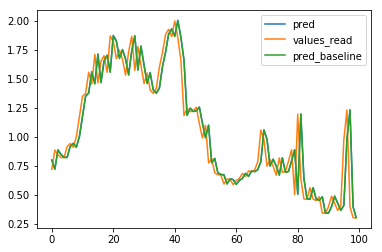

In [42]:
plt.plot(pred, label="pred")
plt.plot(values_read, label="values_read")
plt.plot(pred_baseline, label="pred_baseline")
plt.legend(loc='best')
plt.show()